In [6]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# Input
FILE_NAME = "preliminary_issuer_panel_common70.csv"

# Panel construction
MIN_DAYS_PER_ISSUER = 10
AGG_FUNC = "median"

# Pairwise testing
MIN_OVERLAP_DAYS = 15
DET_ORDER = 0
K_AR_DIFF = 1

# Outputs
OUT_ALL_PAIRS = "pairwise_johansen_results_all_pairs.csv"
OUT_COINT = "pairwise_johansen_results_cointegrated.csv"

In [7]:
# upload using my file name
FILE_NAME = "preliminary_issuer_panel_common70.csv"
MIN_DAYS_PER_ISSUER = 10
AGG_FUNC = "median"

print(f"Loading {FILE_NAME} ...")
raw = pd.read_csv(FILE_NAME)

# if it is long format
is_long = {"trd_exctn_dt", "company_symbol", "yld_pt"}.issubset(raw.columns)

if is_long:
    df = raw.copy()
    df["trd_exctn_dt"] = pd.to_datetime(df["trd_exctn_dt"], errors="coerce")
    df["yld_pt"] = pd.to_numeric(df["yld_pt"], errors="coerce")
    df = df.dropna(subset=["trd_exctn_dt", "company_symbol", "yld_pt"])

    # issuer-day aggregation
    if AGG_FUNC == "median":
        issuer_day = df.groupby(["trd_exctn_dt", "company_symbol"])["yld_pt"].median().reset_index()
    elif AGG_FUNC == "mean":
        issuer_day = df.groupby(["trd_exctn_dt", "company_symbol"])["yld_pt"].mean().reset_index()
    else:
        raise ValueError("AGG_FUNC must be 'median' or 'mean'")

    panel = issuer_day.pivot(index="trd_exctn_dt", columns="company_symbol", values="yld_pt").sort_index()

    # coverage filter
    valid_cols = [c for c in panel.columns if panel[c].count() >= MIN_DAYS_PER_ISSUER]
    panel = panel[valid_cols]

else:
    # if it is wide panel
    panel = raw.copy()
    panel.iloc[:, 0] = pd.to_datetime(panel.iloc[:, 0], errors="coerce")
    panel = panel.set_index(panel.columns[0]).sort_index()
    panel = panel.apply(pd.to_numeric, errors="coerce")

print("Panel shape (days x issuers):", panel.shape)
print("Date range:", panel.index.min().date(), "→", panel.index.max().date())
print("Issuers:", panel.shape[1])

missing_by_day = panel.isna().sum(axis=1)
print("Days with any missing issuer:", int((missing_by_day > 0).sum()), "out of", panel.shape[0])

panel_common = panel.dropna().copy()
print("Common-sample panel shape:", panel_common.shape)

Loading preliminary_issuer_panel_common70.csv ...
Panel shape (days x issuers): (70, 25)
Date range: 2025-11-03 → 2026-02-13
Issuers: 25
Days with any missing issuer: 0 out of 70
Common-sample panel shape: (70, 25)


/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [8]:
def johansen_cointegration_test(series1, series2, det_order=0, k_ar_diff=1):
    """Johansen trace test for rank=0 with 2 series. Returns beta (normalized) for screening."""
    data = np.column_stack([series1, series2])
    data = data[~np.isnan(data).any(axis=1)]
    if data.shape[0] < 10:
        return {"cointegrated": False, "trace_stat": np.nan, "crit_95": np.nan, "beta": None}

    jres = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)

    trace_stat = float(jres.lr1[0])
    crit_95 = float(jres.cvt[0, 1])
    is_coint = trace_stat > crit_95

    beta = jres.evec[:, 0].copy()
    # Normalize beta so beta[0] = 1 for interpretability
    if beta[0] != 0:
        beta = beta / beta[0]

    return {"cointegrated": bool(is_coint), "trace_stat": trace_stat, "crit_95": crit_95, "beta": beta}

def fit_vecm_rank1(pair_df, k_ar_diff=1, det="co"):
    """Fit rank-1 VECM on a 2-column DataFrame. Extract alpha/beta and equilibrium error."""
    pair_df = pair_df.dropna()
    if pair_df.shape[1] != 2:
        raise ValueError("pair_df must have exactly 2 columns.")
    if len(pair_df) < max(15, 5 + 2 * k_ar_diff):
        return None

    model = VECM(pair_df.astype(float), k_ar_diff=k_ar_diff, coint_rank=1, deterministic=det)
    res = model.fit()

    beta = res.beta[:, 0].copy()
    alpha = res.alpha[:, 0].copy()

    # Normalize beta so beta[0] = 1; adjust alpha so alpha*beta' is invariant
    scale = beta[0] if beta[0] != 0 else 1.0
    beta_norm = beta / scale
    alpha_adj = alpha * scale

    eq_error = pair_df.values @ beta_norm
    eq_error = pd.Series(eq_error, index=pair_df.index, name="equilibrium_error")

    return {"beta": beta_norm, "alpha": alpha_adj, "eq_error": eq_error, "vecm_res": res}

def estimate_mean_reversion(residual, hac_lags=5):
    """
    Mean-reversion on equilibrium error via AR(1):
      e_t = a + phi e_{t-1} + eps
    Returns phi, half-life, HAC t-stat for phi, and nobs.
    """
    e = pd.Series(residual).dropna()
    if len(e) < 12:
        return np.nan, np.nan, np.nan, int(len(e))

    e_lag = e.shift(1).dropna()
    e_now = e.loc[e_lag.index]

    X = sm.add_constant(e_lag.values)
    y = e_now.values

    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    phi = float(model.params[1])
    t_stat = float(model.tvalues[1])
    n_obs = int(model.nobs)

    if abs(phi) < 1 and abs(phi) > 0:
        half_life = float(-np.log(2) / np.log(abs(phi)))
    elif abs(phi) == 0:
        half_life = 0.0
    else:
        half_life = np.inf

    return phi, half_life, t_stat, n_obs

def estimate_ecm_alpha_stats(pair_df, eq_error_series, k_ar_diff=1, hac_lags=5):
    pair_df = pair_df.dropna()
    if pair_df.shape[1] != 2:
        raise ValueError("pair_df must have exactly 2 columns.")
    if eq_error_series is None:
        return np.nan, np.nan, np.nan, np.nan, 0

    y = pair_df.astype(float)
    dy = y.diff()

    e_lag = pd.Series(eq_error_series, index=y.index).shift(1)

    # Build design matrix: const + e_{t-1} + lagged Δy terms for both series
    X = pd.DataFrame(index=y.index)
    X["e_lag"] = e_lag

    for L in range(1, k_ar_diff + 1):
        X[f"dy1_lag{L}"] = dy.iloc[:, 0].shift(L)
        X[f"dy2_lag{L}"] = dy.iloc[:, 1].shift(L)

    # Targets: Δy1_t and Δy2_t
    Y1 = dy.iloc[:, 0]
    Y2 = dy.iloc[:, 1]

    # Align and drop missing
    data = pd.concat([Y1.rename("dy1"), Y2.rename("dy2"), X], axis=1).dropna()
    if len(data) < max(12, 5 + 2 * k_ar_diff):
        return np.nan, np.nan, np.nan, np.nan, int(len(data))

    Xmat = sm.add_constant(data.drop(columns=["dy1", "dy2"]).values)

    # Eqn 1
    m1 = sm.OLS(data["dy1"].values, Xmat).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    a1 = float(m1.params[1])     # coefficient on e_lag (after const)
    a1_t = float(m1.tvalues[1])

    # Eqn 2
    m2 = sm.OLS(data["dy2"].values, Xmat).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    a2 = float(m2.params[1])
    a2_t = float(m2.tvalues[1])

    return a1, a1_t, a2, a2_t, int(m1.nobs)

In [9]:
# pairwise
companies = list(panel_common.columns)
n_pairs = len(companies) * (len(companies) - 1) // 2
print(f"Running pairwise tests over {len(companies)} issuers ({n_pairs} pairs)")

results = []

for c1, c2 in itertools.combinations(companies, 2):
    pair_df = panel_common[[c1, c2]].dropna()
    n_overlap = int(len(pair_df))
    if n_overlap < MIN_OVERLAP_DAYS:
        continue

    # Johansen screening
    jt = johansen_cointegration_test(
        pair_df[c1].values,
        pair_df[c2].values,
        det_order=DET_ORDER,
        k_ar_diff=K_AR_DIFF
    )

    if not jt["cointegrated"] or jt["beta"] is None:
        results.append({
            "issuer_1": c1,
            "issuer_2": c2,
            "n_overlap_days": n_overlap,
            "cointegrated": False,
            "trace_stat": jt["trace_stat"],
            "crit_95": jt["crit_95"],
            "beta1": np.nan,
            "beta2": np.nan,
            "alpha1_vecm": np.nan,
            "alpha2_vecm": np.nan,
            "alpha1_ecm": np.nan,
            "alpha1_ecm_t": np.nan,
            "alpha2_ecm": np.nan,
            "alpha2_ecm_t": np.nan,
            "ecm_nobs": np.nan,
            "phi": np.nan,
            "half_life_days": np.nan,
            "phi_t_stat_hac": np.nan
        })
        continue

    # VECM
    vecm_out = fit_vecm_rank1(pair_df, k_ar_diff=K_AR_DIFF, det="co")
    if vecm_out is None:
        results.append({
            "issuer_1": c1,
            "issuer_2": c2,
            "n_overlap_days": n_overlap,
            "cointegrated": True,
            "trace_stat": jt["trace_stat"],
            "crit_95": jt["crit_95"],
            "beta1": float(jt["beta"][0]),
            "beta2": float(jt["beta"][1]),
            "alpha1_vecm": np.nan,
            "alpha2_vecm": np.nan,
            "alpha1_ecm": np.nan,
            "alpha1_ecm_t": np.nan,
            "alpha2_ecm": np.nan,
            "alpha2_ecm_t": np.nan,
            "ecm_nobs": np.nan,
            "phi": np.nan,
            "half_life_days": np.nan,
            "phi_t_stat_hac": np.nan
        })
        continue

    beta = vecm_out["beta"]
    alpha = vecm_out["alpha"]
    eq_error_series = vecm_out["eq_error"]

    # mean reversion
    phi, half_life, phi_t_hac, nobs_phi = estimate_mean_reversion(eq_error_series.values, hac_lags=5)

    a1_ecm, a1_t, a2_ecm, a2_t, ecm_nobs = estimate_ecm_alpha_stats(
        pair_df, eq_error_series, k_ar_diff=K_AR_DIFF, hac_lags=5
    )

    results.append({
        "issuer_1": c1,
        "issuer_2": c2,
        "n_overlap_days": n_overlap,
        "cointegrated": True,
        "trace_stat": jt["trace_stat"],
        "crit_95": jt["crit_95"],
        "beta1": float(beta[0]),
        "beta2": float(beta[1]),
        "alpha1_vecm": float(alpha[0]),
        "alpha2_vecm": float(alpha[1]),
        "alpha1_ecm": float(a1_ecm) if np.isfinite(a1_ecm) else np.nan,
        "alpha1_ecm_t": float(a1_t) if np.isfinite(a1_t) else np.nan,
        "alpha2_ecm": float(a2_ecm) if np.isfinite(a2_ecm) else np.nan,
        "alpha2_ecm_t": float(a2_t) if np.isfinite(a2_t) else np.nan,
        "ecm_nobs": int(ecm_nobs),
        "phi": float(phi),
        "half_life_days": float(half_life) if np.isfinite(half_life) else np.inf,
        "phi_t_stat_hac": float(phi_t_hac)
    })

results_df = pd.DataFrame(results)
print("Pairs evaluated:", len(results_df))
results_df.head()

Running pairwise tests over 25 issuers (300 pairs)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Pairs evaluated: 300


,issuer_1,issuer_2,n_overlap_days,cointegrated,trace_stat,crit_95,beta1,beta2,alpha1_vecm,alpha2_vecm,alpha1_ecm,alpha1_ecm_t,alpha2_ecm,alpha2_ecm_t,ecm_nobs,phi,half_life_days,phi_t_stat_hac
0,AAPL,ABBV,70,True,23.292573,15.4943,1.0,1.783534,-0.109335,-0.230274,-0.109335,-2.495469,-0.230274,-4.611654,68,0.346628,0.654219,2.102594
1,AAPL,AEP,70,True,44.085339,15.4943,1.0,-1.091708,-0.253458,0.763266,-0.253458,-1.399360,0.763266,2.802758,68,-0.068961,0.259196,-0.484427
2,AAPL,AMZN,70,True,35.246664,15.4943,1.0,-0.647095,-0.200979,1.011880,-0.200979,-2.540443,1.011880,4.862164,68,0.171187,0.392718,1.652249
3,AAPL,CAT,70,True,22.973498,15.4943,1.0,-0.714878,-0.534848,-0.005059,-0.534848,-2.990507,-0.005059,-0.047813,68,0.299437,0.574820,2.470915
4,AAPL,COP,70,True,27.686902,15.4943,1.0,-0.475274,-0.588004,0.212257,-0.588004,-4.249521,0.212257,1.068165,68,0.043888,0.221728,0.307564


In [10]:
results_df.to_csv(OUT_ALL_PAIRS, index=False)

cointegrated_df = results_df[
    (results_df["cointegrated"]) &
    (results_df["phi"].abs() < 1)
].copy().sort_values("half_life_days")

cointegrated_df.to_csv(OUT_COINT, index=False)

print("Saved:")
print(" -", OUT_ALL_PAIRS)
print(" -", OUT_COINT)

print("\nTop 20 cointegrated & mean-reverting pairs (shortest half-life):")
cointegrated_df.head(20)

Saved:
 - pairwise_johansen_results_all_pairs.csv
 - pairwise_johansen_results_cointegrated.csv

Top 20 cointegrated & mean-reverting pairs (shortest half-life):


,issuer_1,issuer_2,n_overlap_days,cointegrated,trace_stat,crit_95,beta1,beta2,alpha1_vecm,alpha2_vecm,alpha1_ecm,alpha1_ecm_t,alpha2_ecm,alpha2_ecm_t,ecm_nobs,phi,half_life_days,phi_t_stat_hac
50,AEP,CVX,70,True,47.062534,15.4943,1.0,-1.105575,-0.436406,0.618332,-0.436406,-1.992690,0.618332,5.203963,68,0.000158,0.079212,0.001802
38,ABBV,MS,70,True,34.298607,15.4943,1.0,-1.565090,-0.341613,0.296070,-0.341613,-1.428362,0.296070,2.235002,68,-0.000483,0.090784,-0.002749
159,DUK,PFE,70,True,57.370448,15.4943,1.0,-0.914989,-0.587388,0.601609,-0.587388,-2.076491,0.601609,2.469974,68,-0.000933,0.099341,-0.012500
96,CAT,HON,70,True,36.318471,15.4943,1.0,-1.190198,-0.017390,0.846632,-0.017390,-0.218617,0.846632,6.752044,68,0.001907,0.110689,0.017674
54,AEP,HD,70,True,39.689418,15.4943,1.0,-0.742501,-0.773478,0.256950,-0.773478,-3.149245,0.256950,1.280157,68,-0.002140,0.112759,-0.019660
262,MRK,WMT,70,True,49.672945,15.4943,1.0,-1.254163,-0.631759,0.461871,-0.631759,-5.446660,0.461871,3.563487,68,0.002920,0.118768,0.044180
112,COP,GOOG,70,True,28.294592,15.4943,1.0,-1.494346,-0.089840,0.470856,-0.089840,-2.020209,0.470856,4.358621,68,-0.003472,0.122400,-0.025347
297,SBUX,WMT,70,True,33.141913,15.4943,1.0,-1.207659,0.014315,0.807662,0.014315,0.284051,0.807662,6.668225,68,-0.003511,0.122643,-0.024497
149,DUK,HD,70,True,45.357090,15.4943,1.0,-0.795877,-0.952783,0.151610,-0.952783,-9.903186,0.151610,1.617306,68,0.004021,0.125659,0.122502
279,NEE,NKE,70,True,40.455377,15.4943,1.0,-0.486922,-0.205556,1.564966,-0.205556,-1.878302,1.564966,4.426749,68,-0.004074,0.125953,-0.041296


In [11]:
# Regime switching
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

MAX_REGIME_PAIRS = 50
REGIMES = 2
REGIME_AR_ORDER = 1

MIN_REGIME_OBS = 40

# Use these columns from results_df
print("results_df columns:", list(results_df.columns))

eligible = results_df.copy()

# Use the best-available mean-reversion column names
eligible = eligible[eligible["cointegrated"] == True].copy()

# Drop non-mean-reverting or missing phi
eligible = eligible[np.isfinite(eligible["phi"])].copy()
eligible = eligible[eligible["phi"].abs() < 1].copy()

# Require some minimum overlap
eligible = eligible[eligible["n_overlap_days"] >= MIN_REGIME_OBS].copy()

print("Eligible pairs for regime switching:", len(eligible))

eligible = eligible.sort_values(["half_life_days", "trace_stat"], ascending=[True, False])

if MAX_REGIME_PAIRS is not None:
    eligible = eligible.head(MAX_REGIME_PAIRS).copy()

eligible[['issuer_1','issuer_2','n_overlap_days','phi','half_life_days','trace_stat']].head(10)

results_df columns: ['issuer_1', 'issuer_2', 'n_overlap_days', 'cointegrated', 'trace_stat', 'crit_95', 'beta1', 'beta2', 'alpha1_vecm', 'alpha2_vecm', 'alpha1_ecm', 'alpha1_ecm_t', 'alpha2_ecm', 'alpha2_ecm_t', 'ecm_nobs', 'phi', 'half_life_days', 'phi_t_stat_hac']
Eligible pairs for regime switching: 300


,issuer_1,issuer_2,n_overlap_days,phi,half_life_days,trace_stat
50,AEP,CVX,70,0.000158,0.079212,47.062534
38,ABBV,MS,70,-0.000483,0.090784,34.298607
159,DUK,PFE,70,-0.000933,0.099341,57.370448
96,CAT,HON,70,0.001907,0.110689,36.318471
54,AEP,HD,70,-0.002140,0.112759,39.689418
262,MRK,WMT,70,0.002920,0.118768,49.672945
112,COP,GOOG,70,-0.003472,0.122400,28.294592
297,SBUX,WMT,70,-0.003511,0.122643,33.141913
149,DUK,HD,70,0.004021,0.125659,45.357090
279,NEE,NKE,70,-0.004074,0.125953,40.455377


In [12]:
# Markov-switching AR(1)
def compute_eq_error_from_beta(pair_df, beta1, beta2):
    """e_t = beta1*y1_t + beta2*y2_t (beta1 is typically 1.0 by normalization)."""
    y = pair_df.values.astype(float)
    beta = np.array([beta1, beta2], dtype=float)
    return pd.Series(y @ beta, index=pair_df.index, name="equilibrium_error")

regime_rows = []

for _, row in eligible.iterrows():
    c1, c2 = row["issuer_1"], row["issuer_2"]
    pair_df = panel_common[[c1, c2]].dropna()
    if len(pair_df) < MIN_REGIME_OBS:
        continue

    # Use VECM beta columns
    beta1 = float(row["beta1"])
    beta2 = float(row["beta2"])
    e = compute_eq_error_from_beta(pair_df, beta1, beta2).dropna()

    # Fit 2-regime switching AR(1) with switching intercept and variance
    try:
        mr = MarkovRegression(
            e,
            k_regimes=REGIMES,
            trend='c',
            order=REGIME_AR_ORDER,
            switching_variance=True
        )
        mres = mr.fit(disp=False, maxiter=200)

        p = mres.params
        # Transition probs:
        # p[ 'p[0->0]' ], p['p[1->1]'] sometimes appear in param names; otherwise parse
        param_names = list(getattr(mres, 'param_names', []))
        params = dict(zip(param_names, p)) if param_names else {}

        def get_param(key_substr):
            for k,v in params.items():
                if key_substr in k:
                    return float(v)
            return np.nan

        p00 = get_param("p[0->0]")
        p11 = get_param("p[1->1]")

        phi0 = get_param("ar.L1[0]")
        phi1 = get_param("ar.L1[1]")

        mu0 = get_param("const[0]")
        mu1 = get_param("const[1]")

        s20 = get_param("sigma2[0]")
        s21 = get_param("sigma2[1]")

        smoothed = mres.smoothed_marginal_probabilities
        avg_prob_regime1 = float(smoothed[1].mean()) if 1 in smoothed.columns else np.nan

        regime_rows.append({
            "issuer_1": c1,
            "issuer_2": c2,
            "n_obs": int(len(e)),
            "ms_loglike": float(mres.llf),
            "ms_aic": float(mres.aic),
            "p00": p00,
            "p11": p11,
            "mu0": mu0,
            "mu1": mu1,
            "phi0": phi0,
            "phi1": phi1,
            "sigma2_0": s20,
            "sigma2_1": s21,
            "avg_smoothed_prob_regime1": avg_prob_regime1
        })
    except Exception as ex:
        regime_rows.append({
            "issuer_1": c1,
            "issuer_2": c2,
            "n_obs": int(len(e)),
            "ms_loglike": np.nan,
            "ms_aic": np.nan,
            "p00": np.nan,
            "p11": np.nan,
            "mu0": np.nan,
            "mu1": np.nan,
            "phi0": np.nan,
            "phi1": np.nan,
            "sigma2_0": np.nan,
            "sigma2_1": np.nan,
            "avg_smoothed_prob_regime1": np.nan,
            "error": str(ex)[:200]
        })

regime_df = pd.DataFrame(regime_rows)
regime_df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1283: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(smoothed_joint_probabilities[j, i]) /
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/regime_switching/markov_regression.py:272: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(resid**2 *
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pr

,issuer_1,issuer_2,n_obs,ms_loglike,ms_aic,p00,p11,mu0,mu1,phi0,phi1,sigma2_0,sigma2_1,avg_smoothed_prob_regime1,error
0,AEP,CVX,70,52.64302,-93.28604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95746,NaN
1,ABBV,MS,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Steady-state probabilities could not be constr...
2,DUK,PFE,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVD did not converge
3,CAT,HON,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Steady-state probabilities could not be constr...
4,AEP,HD,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Steady-state probabilities could not be constr...


In [13]:
REGIME_OUT = "markov_switching_results.csv"
regime_df.to_csv(REGIME_OUT, index=False)
print("Saved:", REGIME_OUT)

# check |phi1| < |phi0|
tmp = regime_df.dropna(subset=["phi0","phi1"]).copy()
tmp["regime1_more_MR"] = (tmp["phi1"].abs() < tmp["phi0"].abs())
tmp.sort_values("ms_aic").head(10)

Saved: markov_switching_results.csv


,issuer_1,issuer_2,n_obs,ms_loglike,ms_aic,p00,p11,mu0,mu1,phi0,phi1,sigma2_0,sigma2_1,avg_smoothed_prob_regime1,error,regime1_more_MR


In [14]:
# Network mapping
import networkx as nx
import matplotlib.pyplot as plt

# Edge eligibility rules
edges = results_df.copy()
edges = edges[edges["cointegrated"] == True].copy()
edges = edges[np.isfinite(edges["phi"])].copy()
edges = edges[edges["phi"].abs() < 1].copy()

# Choose weight scheme
def compute_edge_weight(row, mode="mr"):
    if mode == "mr":
        hl = row["half_life_days"]
        if not np.isfinite(hl) or hl <= 0:
            return np.nan
        return 1.0 / hl
    elif mode == "trace":
        return float(row["trace_stat"])
    elif mode == "alpha":
        a1 = row.get("alpha1_ecm", np.nan)
        a2 = row.get("alpha2_ecm", np.nan)
        if np.isnan(a1) and np.isnan(a2):
            return np.nan
        return float(np.nanmax([abs(a1), abs(a2)]))
    else:
        return 1.0

WEIGHT_MODE = "mr"
edges["weight"] = edges.apply(lambda r: compute_edge_weight(r, mode=WEIGHT_MODE), axis=1)
edges = edges.dropna(subset=["weight"]).copy()

print("Edges in network:", len(edges))

# Build
G = nx.Graph()
for _, r in edges.iterrows():
    G.add_edge(r["issuer_1"], r["issuer_2"], weight=float(r["weight"]),
               half_life=float(r["half_life_days"]),
               trace=float(r["trace_stat"]),
               phi=float(r["phi"]))

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

Edges in network: 300
Nodes: 25 Edges: 300


In [15]:
# Centrality measures
deg = dict(G.degree())
wdeg = dict(G.degree(weight="weight"))
between = nx.betweenness_centrality(G, weight="weight", normalized=True) if G.number_of_edges() > 0 else {}
eig = {}
try:
    eig = nx.eigenvector_centrality(G, weight="weight", max_iter=1000) if G.number_of_edges() > 0 else {}
except Exception:
    eig = {n: np.nan for n in G.nodes()}

node_df = pd.DataFrame({
    "issuer": list(G.nodes()),
    "degree": [deg.get(n, 0) for n in G.nodes()],
    "weighted_degree": [wdeg.get(n, 0.0) for n in G.nodes()],
    "betweenness": [between.get(n, np.nan) for n in G.nodes()],
    "eigenvector": [eig.get(n, np.nan) for n in G.nodes()],
}).sort_values("weighted_degree", ascending=False)

EDGE_OUT = "network_edges.csv"
NODE_OUT = "network_nodes.csv"

edges_out = edges[["issuer_1","issuer_2","weight","half_life_days","trace_stat","phi",
                   "alpha1_vecm","alpha2_vecm","alpha1_ecm","alpha1_ecm_t","alpha2_ecm","alpha2_ecm_t"]].copy()

edges_out.to_csv(EDGE_OUT, index=False)
node_df.to_csv(NODE_OUT, index=False)

print("Saved:", EDGE_OUT)
print("Saved:", NODE_OUT)

node_df.head(10)

Saved: network_edges.csv
Saved: network_nodes.csv


,issuer,degree,weighted_degree,betweenness,eigenvector
7,DUK,24,116.677067,0.000000,0.262489
6,CVX,24,114.293906,0.000000,0.261669
19,NKE,24,112.727605,0.000000,0.251514
2,AEP,24,103.598281,0.000000,0.243734
12,JNJ,24,97.529346,0.000000,0.220314
15,MRK,24,96.759571,0.000000,0.224713
11,HON,24,93.553846,0.000000,0.210320
23,WMT,24,90.720694,0.000000,0.209097
20,PFE,24,90.702711,0.000000,0.214863
14,KO,24,88.780608,0.003623,0.209430


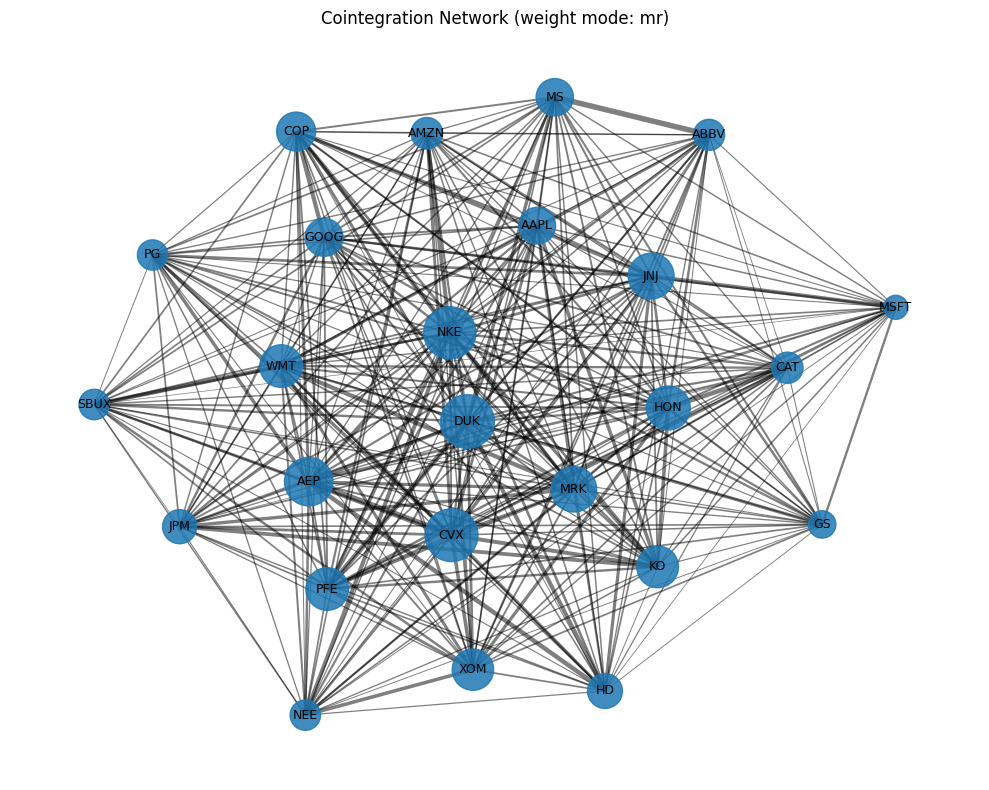

In [16]:
# network plot
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42, k=0.6)

# Node sizes
sizes = np.array([node_df.set_index("issuer").loc[n, "weighted_degree"] for n in G.nodes()])
sizes = 300 + 1200 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)

# Edge widths by weight
edge_weights = np.array([G[u][v]["weight"] for u,v in G.edges()])
edge_widths = 0.5 + 4.0 * (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-9)

nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.85)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title(f"Cointegration Network (weight mode: {WEIGHT_MODE})")
plt.axis("off")
plt.tight_layout()
plt.show()